In [1]:
import numpy as np
import glob
import random
import imageio
import PIL, cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

In [2]:
DATA_DIR = "C:/Users/ADMIN/Desktop/real/"
list_dirs = list(glob.glob(DATA_DIR+"*.JPEG"))
print(list_dirs)
num_images = len(list_dirs)
num_images

['C:/Users/ADMIN/Desktop/real\\image1.jpeg', 'C:/Users/ADMIN/Desktop/real\\image2.jpeg', 'C:/Users/ADMIN/Desktop/real\\image3.jpeg', 'C:/Users/ADMIN/Desktop/real\\image4.jpeg', 'C:/Users/ADMIN/Desktop/real\\image5.jpeg']


5

In [3]:
display_list = list_dirs[0:5]

image1 = imageio.imread(display_list[0])
image2 = imageio.imread(display_list[1])
image3 = imageio.imread(display_list[2])

In [4]:
THRESHOLD1 = image1.mean()
image1 = np.array(image1 > THRESHOLD1).astype(int) * 255

In [5]:
def getTerminationBifurcation(img, mask):
    img = img == 255;
    (rows, cols) = img.shape;
    minutiaeTerm = np.zeros(img.shape);
    minutiaeBif = np.zeros(img.shape);
    
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if(img[i][j] == 1):
                block = img[i-1:i+2,j-1:j+2];
                block_val = np.sum(block);
                if(block_val == 2):
                    minutiaeTerm[i,j] = 1;
                elif(block_val == 4):
                    minutiaeBif[i,j] = 1;
    
    mask = convex_hull_image(mask>0)
    mask = erosion(mask, square(5))         
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return(minutiaeTerm, minutiaeBif)

In [6]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX;
        self.locY = locY;
        self.Orientation = Orientation;
        self.Type = Type;

def computeAngle(block, minutiaeType):
    angle = 0
    (blkRows, blkCols) = np.shape(block);
    CenterX, CenterY = (blkRows-1)/2, (blkCols-1)/2
    if(minutiaeType.lower() == 'termination'):
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if((i == 0 or i == blkRows-1 or j == 0 or j == blkCols-1) and block[i][j] != 0):
                    angle = -math.degrees(math.atan2(i-CenterY, j-CenterX))
                    sumVal += 1
                    if(sumVal > 1):
                        angle = float('nan');
        return(angle)
    elif(minutiaeType.lower() == 'bifurcation'):
        (blkRows, blkCols) = np.shape(block);
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        angle = []
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                    angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if(sumVal != 3):
            angle = float('nan')
        return(angle)


def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []

    minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeTerm)
    
    WindowSize = 2          
    FeaturesTerm = []
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeBif)
    WindowSize = 1 
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
    return(FeaturesTerm, FeaturesBif)

def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0;
    minutiaeTerm = BifLabel * 0;

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel;
    DispImg[:, :, 1] = skel;
    DispImg[:, :, 2] = skel;

    RP = skimage.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0));

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255));
        
    plt.figure(figsize=(6,6))
    plt.title("Minutiae extraction results")
    plt.imshow(DispImg)

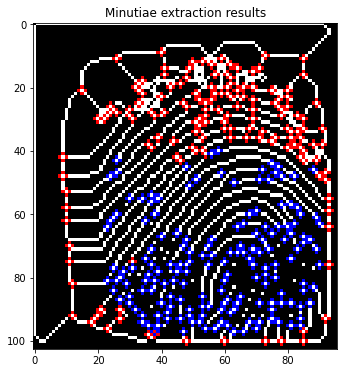

In [7]:
img_name = display_list[1]
img = cv2.imread(img_name,0);
img = np.array(img > THRESHOLD1).astype(int)
skel = skimage.morphology.skeletonize(img)
skel = np.uint8(skel)*255;
mask = img*255;

(minutiaeTerm, minutiaeBif) = getTerminationBifurcation(skel, mask);
FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif)
BifLabel = skimage.measure.label(minutiaeBif, connectivity=1);
TermLabel = skimage.measure.label(minutiaeTerm, connectivity=1);
ShowResults(skel, TermLabel, BifLabel)